# SwinUnet With Sentinel 1


## Content

1. [Installation](#installation)
1. [Dataset](#dataset)
1. [Quick Start](#quickstart)

<a id='installation'></a>
## 1. Installation

#### Dependencies

This project uses Python 3.8, and the dependencies listed in `requirements.txt` can be installed with `pip` or `conda`, in a virtual environment. For example, using `pip`:


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
path_to_module_1 = '/content/drive/My Drive/Projet Computer Vision/LandCover_map_Transformers_SSL/src'
sys.path.append(path_to_module_1)

In [4]:
!pip install rasterio
!pip install einops
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 797.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.5 MB/s eta 0:00:00


In [5]:
# Import needed packages
import torch
from tqdm import tqdm
import matplotlib.pyplot  as plt
import torch.nn as nn
import random
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from pathlib import Path

from tools.utils import PixelwiseMetrics, AverageMeter, generate_miou, print_metrics, generate_metrics_acc, print_metrics_acc
from SwinUnet.vision_transformer import SwinUnet
from tools.dfc_dataset import DFCDataset


<a id='dataset'></a>
## 2. Dataset


#### Download

 In this notebook, we will use the DFC2020 dataset to train downstream tasks. You can download it using this [link](https://ieee-dataport.org/competitions/2020-ieee-grss-data-fusion-contest). We are using multimodal input here (fusion of Sentinel-1 and Sentinel-2)


#### Configure

For example, in the `data_config` dictionary (cell below), you can specify paths to the data directory with `train_dir` and `val_dir` or the image input size with `image_px_size`.

In [6]:
# Data configurations:
data_config = {
    'train_dir': '/content/drive/My Drive/train', # path to the training directory,
    'val_dir': '/content/drive/My Drive/val', # path to the validation directory,
    'train_mode': 'validation', # can be one of the following: 'test', 'validation'
    'val_mode': 'test', # can be one of the following: 'test', 'validation'
    'num_classes': 8, # number of classes in the dataset.
    'clip_sample_values': True, # clip (limit) values
    'train_used_data_fraction': 1, # fraction of data to use, should be in the range [0, 1]
    'val_used_data_fraction': 1,
    'image_px_size': 224, # image size (224x224)
    'cover_all_parts_train': True, # if True, if image_px_size is not 224 during training, we use a random crop of the image
    'cover_all_parts_validation': True, # if True, if image_px_size is not 224 during validation, we use a non-overlapping sliding window to cover the entire image
    'seed': 42,
}

In [7]:
# Ensure deterministic behavior

random.seed(data_config['seed'])
np.random.seed(data_config['seed'])
torch.manual_seed(data_config['seed'])
torch.cuda.manual_seed_all(data_config['seed'])

#### Prepare

We create the `train_dataset` and `val_dataset` by using the `DFCDataset`, a custom class of `torch.utils.data.Dataset`

In [8]:
# Create Training Dataset
train_dataset = DFCDataset(
    data_config['train_dir'],
    mode=data_config['train_mode'],
    clip_sample_values=data_config['clip_sample_values'],
    used_data_fraction=data_config['train_used_data_fraction'],
    image_px_size=data_config['image_px_size'],
    cover_all_parts=data_config['cover_all_parts_train'],
    seed=data_config['seed']
)

# Create Validation Dataset
val_dataset = DFCDataset(
    data_config['val_dir'],
    mode=data_config['val_mode'],
    clip_sample_values=data_config['clip_sample_values'],
    used_data_fraction=data_config['val_used_data_fraction'],
    image_px_size=data_config['image_px_size'],
    cover_all_parts=data_config['cover_all_parts_validation'],
    seed=data_config['seed']
)

We can see how many examples are in each split by checking their length:

In [9]:
len(train_dataset), len(val_dataset)

(986, 5128)

We can also display some examples:

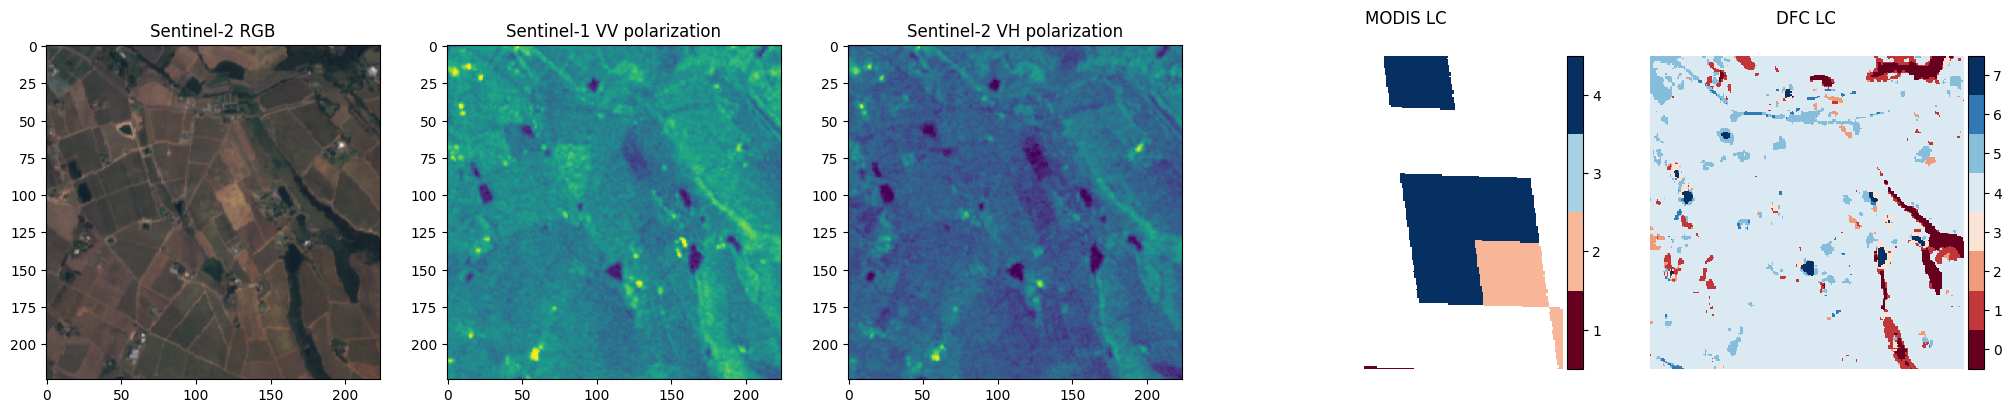

In [10]:
train_dataset.visualize_observation(67)

The plots show, from left to right: Sentinel-2 true color image, Sentinel-1 maps for the two different polarizations, a coarse MODIS LULC map and the high-resolution DFC2020 LULC map.

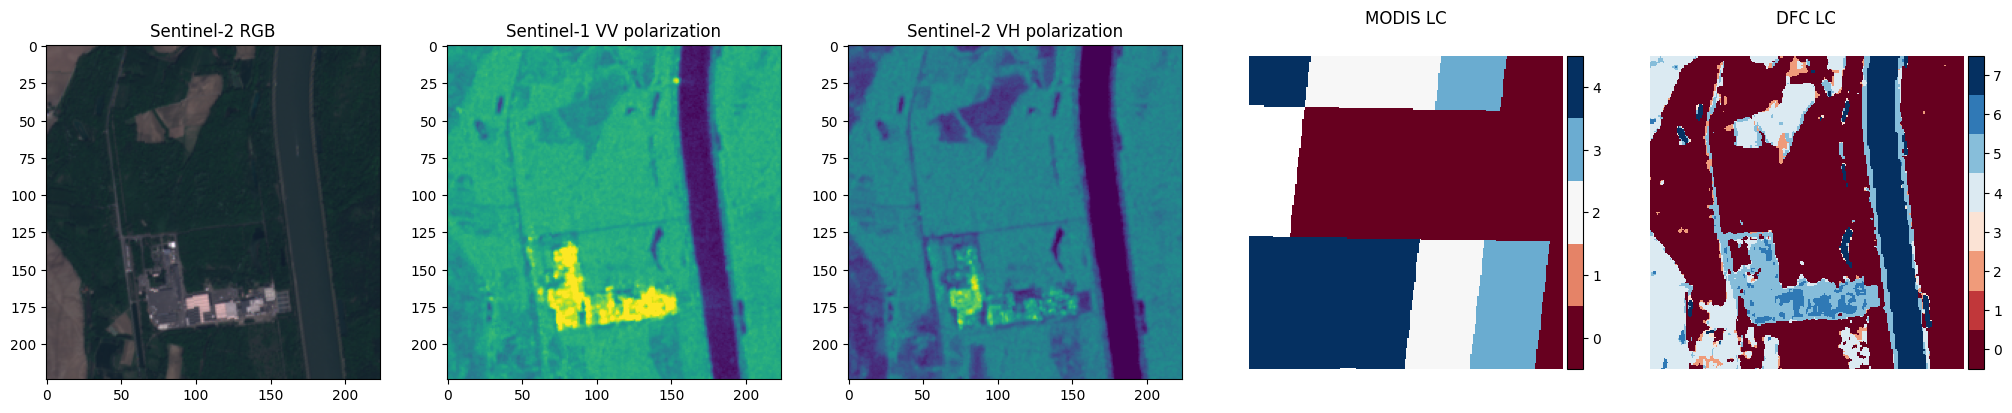

In [11]:
val_dataset.visualize_observation(1)

We define a correspondance of label and names:

In [12]:
DFC_map_clean = {
    0: "Forest",
    1: "Shrubland",
    2: "Grassland",
    3: "Wetlands",
    4: "Croplands",
    5: "Urban/Built-up",
    6: "Barren",
    7: "Water",
    255: "Invalid",
}

Our data is now ready to be used by the model. In the next section we load and configure the model.

<a id='quickstart'></a>
## 3. Quick Start

#### Configure

You can specify in the some hyperparameters in `train_config`  and `model_config` (cell below).

In [13]:
# Training configurations
model_config = {'img_size': 224,
                 'patch_size': 4,
                 'in_chans':2,
                 'num_classes':8,
                 'embed_dim': 96,
                 'depths':[2, 2, 2, 2],
                 'depths_decoder': [1, 2, 2, 2],
                 'num_heads' :[3, 6, 12, 24],
                 'window_size':7,
                  'mlp_ratio' :4.,
                    'qkv_bias' : True,
                    'qk_scale': None,
                 'drop_rate' :0.,
                'attn_drop_rate':0.,
                'drop_path_rate':0.1,
                 'norm_layer': nn.LayerNorm,
                 'ape': False,
                'patch_norm': True,
                 'use_checkpoint' :False,
                 'final_upsample' :"expand_first"
                }

train_config = {
    's1_input_channels': 2,
    's2_input_channels': 13,
    'classifier_lr': 3e-6,
    'learning_rate': 0.00001,
    'adam_betas': (0.9, 0.999),
    'weight_decay': 0.001,
    'dataloader_workers': 4,
    'batch_size': 4,
    'epochs': 30,
    'target': 'dfc'
}

#### Prepare model

In [14]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu:0")

In [15]:
model = SwinUnet(config=model_config, num_classes=data_config['num_classes'])

model = model.to(device)

SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:8


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---final upsample expand_first---


Define and initialise the loss for training.

In [16]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=255, reduction="mean").to(device)

Initialise the selected optimizer. In this work we chose Adam optimizer. You can initialise any optimizer you want.

In [17]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=train_config['learning_rate'],
    betas=train_config['adam_betas'],
    weight_decay=train_config['weight_decay'],
)

We load the data (training and validation) using pytorch's dataloader

In [18]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_config['batch_size'],
    shuffle=True,
    pin_memory=True,
    num_workers=train_config['dataloader_workers'],
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=train_config['batch_size'],
    shuffle=False,
    num_workers=train_config['dataloader_workers'],
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [19]:
# Define the path for saving the model
model_save_path = '/content/drive/My Drive/Checkpoints/SwinUnet_S1_best_model.pth'

Everything is set and we are now ready to train our model:

In [20]:
# Ensure necessary classes like ConfMatrix, PixelwiseMetrics are imported
# from utils import ConfMatrix, PixelwiseMetrics, generate_miou

num_classes = data_config['num_classes']

class EarlyStopping:
    """ Class for early stopping """
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

def train_segmentation_model(epochs, train_loader, val_loader, model, optimizer, criterion, num_classes):
    early_stopper = EarlyStopping(patience=6)
    best_val_loss = float('inf')
    best_model_wts = None

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses, train_metrics = [], PixelwiseMetrics(num_classes)

        for sample in tqdm(train_loader):
            if "x" in sample.keys():
                if torch.isnan(sample["x"]).any():
                    continue
            else:
                if torch.isnan(sample["s1"]).any():
                    continue

            s1 = sample["s1"].to(device)

            y = sample[train_config['target']].long().to(device)
            y = torch.squeeze(y, 1)

            optimizer.zero_grad()
            y_hat = model(s1)

            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            pred = torch.argmax(y_hat, dim=1)
            train_metrics.add_batch(y, pred)

        # Calculate training statistics
        train_loss = np.mean(train_losses)
        train_acc = train_metrics.get_average_accuracy()

        # Validation Phase
        if (epoch +1 ) % 29 == 0:
            model.eval()
            val_losses, val_metrics = [], PixelwiseMetrics(num_classes)
            with torch.no_grad():
                for sample in tqdm(val_loader):
                    if "x" in sample.keys():
                        if torch.isnan(sample["x"]).any():
                            continue
                    else:
                        if torch.isnan(sample["s1"]).any():
                            continue

                    s1 = sample["s1"].to(device)

                    y = sample[train_config['target']].long().to(device)
                    y = torch.squeeze(y, 1)

                    y_hat = model(s1)

                    loss = criterion(y_hat, y)

                    val_losses.append(loss.item())
                    pred = torch.argmax(y_hat, dim=1)
                    val_metrics.add_batch(y, pred)

            # Calculate validation statistics
            val_loss = np.mean(val_losses)
            val_acc = val_metrics.get_average_accuracy()

            # Save the best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_wts = model.state_dict()

            # Early stopping
            early_stopper(val_loss)
            if early_stopper.early_stop:
                print("Early stopping triggered")
                break

    # Save best model weights after training loop
    if best_model_wts:
       os.makedirs(os.path.dirname(model_save_path), exist_ok=True)  # Ensure the directory exists
       torch.save(best_model_wts, model_save_path)
       print(f"Best model saved to {model_save_path}.")

    print("Training completed.")



In [56]:
train_segmentation_model(train_config['epochs'], train_loader, val_loader, model, optimizer, criterion, num_classes)

100%|██████████| 247/247 [02:11<00:00,  1.88it/s]


Best model saved to /content/drive/My Drive/Checkpoints/SwinUnet_S1_best_model.pth.
Training completed.


You can evaluate the model on one example by creating a model's instance, loading checkpoint's weights of the classifier saved during training, running it, and displaying the results:

SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:8
---final upsample expand_first---


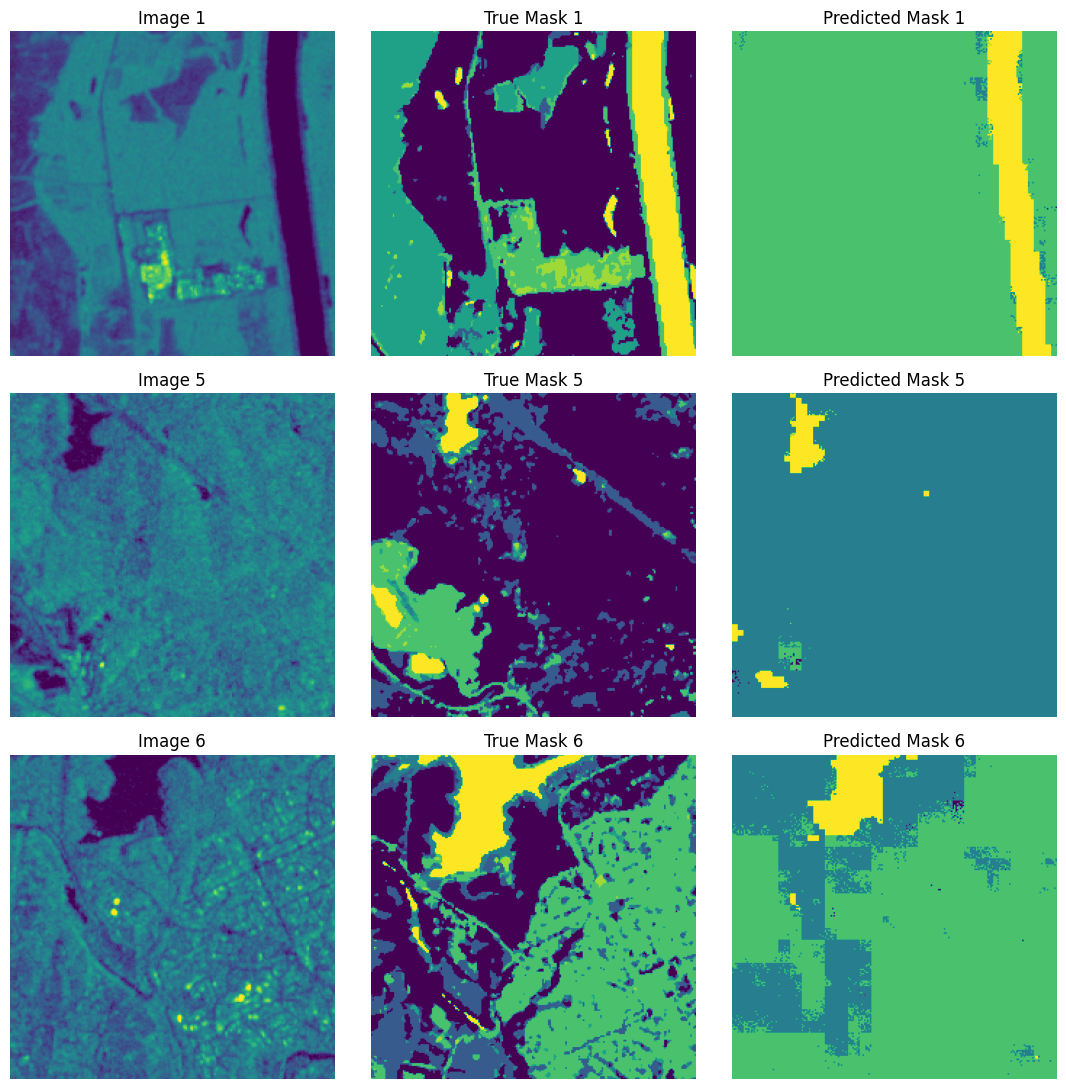

In [26]:
# Create a new instance of the model
model = SwinUnet(model_config, num_classes=8)
model = model.to(device)

# Load checkpoint weights
model.load_state_dict(torch.load(model_save_path))

# Set the model to evaluation mode
model.eval()

indices = [1, 5, 6]

# Create a subplot grid
fig, axes = plt.subplots(3, 3, figsize=(11,11))

for i, idx in enumerate(indices):
    # Prepare the input
    img = torch.unsqueeze(val_dataset[idx]['s1'], 0).to(device)
    true_mask = val_dataset[idx][train_config['target']].squeeze(0)

    # Get the model output
    output = model(img)
    output = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    # Display the image
    single_channel_img = img.squeeze().cpu().numpy()[1, :, :]
    axes[i, 0].imshow(single_channel_img)
    axes[i, 0].set_title(f'Image {idx}')
    axes[i, 0].axis('off')

    # Display the true mask
    axes[i, 1].imshow(true_mask)
    axes[i, 1].set_title(f'True Mask {idx}')
    axes[i, 1].axis('off')

    # Display the predicted mask
    axes[i, 2].imshow(output)
    axes[i, 2].set_title(f'Predicted Mask {idx}')
    axes[i, 2].axis('off')

# Show the plots
plt.tight_layout()
plt.show()


In [51]:
pred_msk  = '/content/drive/My Drive/Projet Computer Vision/pred_SSL_S1_S2'

In [52]:
def predict_and_save(val_dataset, save_path, model, device='cuda'):
    """
    Function to perform predictions on a test dataset and save the results.

    Args:
        test_loader (DataLoader): DataLoader for the test dataset.
        save_path (str): Path where to save the prediction results.
        model (torch.nn.Module): Pre-trained model for making predictions.
        device (str): Device to run the predictions on ('cuda' or 'cpu').
    """
    model.eval()
    model.to(device)

    if not os.path.exists(save_path):
        os.makedirs(save_path)

    with torch.no_grad():
        for i in range(len(val_dataset)):
            img = torch.unsqueeze(val_dataset[i]['s1'], 0).to(device)
            outputs = model(img)

            # Apply argmax to get the most probable class for each pixel
            predicted = torch.argmax(outputs, dim=1).squeeze(0).cpu().numpy()

            # Ensure prediction is a 2D array
            if predicted.ndim != 2:
                raise ValueError(f"Predicted image is not 2D: {predicted.shape}")

            save_file_path = os.path.join(save_path, f'prediction_{i}.npy')
            np.save(save_file_path, predicted)

    print("Predictions successfully saved.")


In [33]:
predict_and_save(val_dataset, pred_msk, model, device='cuda')

Predictions successfully saved.


In [36]:
def generate_miou(test_dataset, path_pred: str, S: str) -> tuple:
    def get_data_paths(path, filter):
        for path in Path(path).rglob(filter):
            yield path.resolve().as_posix()

    def calc_miou(cm_array):
        if cm_array.ndim != 2:
            raise ValueError(f"Confusion matrix is not 2D: {cm_array.shape}")
        ious = np.diag(cm_array) / (cm_array.sum(0) + cm_array.sum(1) - np.diag(cm_array))
        m = np.nanmean(ious[:-1])
        return m, ious[:-1]

    preds_images = sorted(list(get_data_paths(Path(path_pred), 'prediction*.npy')), key=lambda x: int(x.split('_')[-1][:-4]))

    if len(test_dataset) != len(preds_images):
        print('[WARNING !] Mismatch number of predictions and test files.')
    fr = 0
    patch_confusion_matrices = []
    for u in range(len(test_dataset)):

        preds = np.load(preds_images[u])
        if preds.ndim != 2:
            raise ValueError(f"Prediction image is not 2D: {preds.shape}")

        cm = confusion_matrix(test_dataset[u][S].flatten(), preds.flatten(), labels=list(range(13)))
        patch_confusion_matrices.append(cm)

    sum_confmat = np.sum(patch_confusion_matrices, axis=0)
    if sum_confmat.ndim != 2:
        raise ValueError(f"Summed confusion matrix is not 2D: {sum_confmat.shape}")

    mIou, ious = calc_miou(sum_confmat)
    return mIou, ious


In [37]:
mIou, ious = generate_miou(val_dataset, pred_msk, S = 'dfc')
print_metrics(mIou, ious)



----------------------------------------
         Model mIoU :  0.2064
----------------------------------------
Class                     iou            
----------------------------------------
Forest                    0.08783059322855336
Shrubland                 0.005891190023169949
Grassland                 0.019770806736475986
Wetlands                  0.043785321620125855
Croplands                 0.22708050219011436
Urban/Built-up            0.3257329509708067
Barren                    0.04080524295400203
Water                     0.9003181333854037
Invalid                   nan            





<ipython-input-36-ba78110a2f79>:12: RuntimeWarning: invalid value encountered in divide
  ious = np.diag(cm_array) / (cm_array.sum(0) + cm_array.sum(1) - np.diag(cm_array))


In [49]:
def calculate_accuracy(conf_matrix):
    """Calculate classwise and overall accuracy from the confusion matrix."""
    classwise_accuracy = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    overall_accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
    return classwise_accuracy, overall_accuracy

def generate_metrics_acc(test_dataset, path_pred: str, S: str) -> dict:
    def get_data_paths(path, filter):
        for path in Path(path).rglob(filter):
            yield path.resolve().as_posix()

    preds_images = sorted(list(get_data_paths(Path(path_pred), 'prediction*.npy')), key=lambda x: int(x.split('_')[-1][:-4]))

    if len(test_dataset) != len(preds_images):
        print('[WARNING !] Mismatch number of predictions and test files.')

    patch_confusion_matrices = []

    for i in range(len(test_dataset)):

        preds = np.load(preds_images[i])

        # Ensure both target and preds are 2D arrays
        if  preds.ndim != 2:
            raise ValueError(f"Target or prediction image at index {i} is not 2D.")

        patch_confusion_matrices.append(confusion_matrix(test_dataset[i][S].flatten(), preds.flatten(), labels=list(range(13))))

    sum_confmat = np.sum(patch_confusion_matrices, axis=0)
    classwise_accuracy, overall_accuracy = calculate_accuracy(sum_confmat)

    return {
        "classwise_accuracy": classwise_accuracy,
        "overall_accuracy": overall_accuracy
    }

In [50]:
metrics = generate_metrics_acc(val_dataset, pred_msk, S="dfc")
classwise_accuracy = metrics["classwise_accuracy"]
overall_accuracy = metrics["overall_accuracy"]
print_metrics_acc(overall_accuracy, classwise_accuracy)



----------------------------------------
         Model Accuracy :  0.4144
----------------------------------------
Class                     accuracy       
----------------------------------------
Forest                    0.0909222189863578
Shrubland                 0.006345887314151446
Grassland                 0.03288252716641852
Wetlands                  0.47356396375079596
Croplands                 0.39353113423185093
Urban/Built-up            0.6847941629688503
Barren                    0.06812540311462063
Water                     0.9655362039325144
Invalid                   nan            





<ipython-input-49-e322326379fd>:3: RuntimeWarning: invalid value encountered in divide
  classwise_accuracy = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
